#### This notebook shows how to read the CMRxRecon dataset and apply some simple transformations to the data.
#### We utilized some useful codes from fastMRI repo.

In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import hdf5storage


/home/blevac/anaconda3/envs/cmr-data/lib/python3.9/site-packages/hdf5storage/utilities.py:44: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


The CMRxRecon dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we first show how to open a file from the multi-coil dataset. Each file corresponds to ntime * nslice of MRI scan and contains the k-space data.

In [21]:
file_name = '/csiNAS3/mridata/CMRxRecon/DemoData/P001/cine_lax_ks.mat'
hf_m = h5py.File(file_name)

In [22]:
print('Keys:', list(hf_m.keys()))

Keys: ['Recon_ks']


In [23]:
# here to load the kspace data
newvalue = hf_m['Recon_ks']
fullmulti = newvalue["real"] + 1j*newvalue["imag"]

In [24]:
[nframe, nslice, ncoil, ny, nx] = fullmulti.shape
print(nframe, nslice, ncoil, ny, nx)

19 3 30 204 448


In multi-coil MRIs, k-space has the following shape: 

#number of frame, number of slices, number of coils, ny, nx (ny is the phase encoding direction for undersampling)

For single-coil MRIs, k-space has the following shape: #number of frame, number of slices, ny, nx


In [26]:
# choose the first frame and the middle slice
slice_kspace = fullmulti[0,2] 

Let's see what the absolute value of k-space looks like:

In [27]:
def show_coils(data, slice_nums, cmap=None, vmax = 0.0005):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap,vmax=vmax)

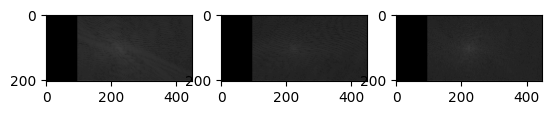

In [28]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 4, 9], cmap='gray', vmax = 0.0001)  # This shows coils 0, 5 and 9

We acknowledged fastMRI repo for their utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [29]:
import fastmri
from fastmri.data import transforms as T

In [30]:
slice_kspace2 = T.to_tensor(slice_kspace)              # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

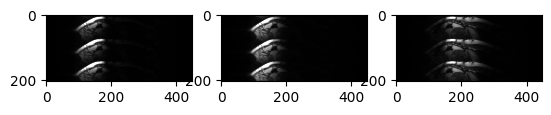

In [31]:
show_coils(slice_image_abs, [0, 3, 6], cmap='gray', vmax = 0.0005)

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [32]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

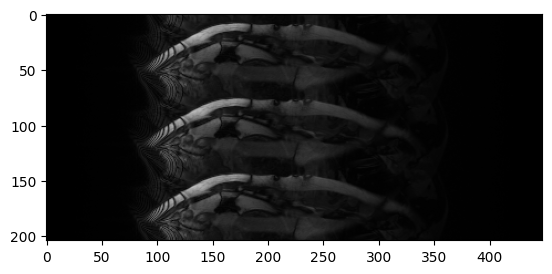

In [33]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray', vmax = 0.0015)

So far, we have been looking at fully-sampled multi-coil data. We can also apply the similar operator to the undersampled single-coil data to see how it can be changed to image domain.

In [20]:
file_name = '/media/NAS_CMR/CMRxRecon/ChallengeData/SingleCoil/Cine/TrainingSet/AccFactor04/P001/cine_sax.mat'
hf_s = h5py.File(file_name)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/media/NAS_CMR/CMRxRecon/ChallengeData/SingleCoil/Cine/TrainingSet/AccFactor04/P001/cine_sax.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [15]:
print('Keys:', list(hf_s.keys()))

Keys: ['kspace_single_sub04']


In [16]:
# here to load the kspace data, the keys are differnt for different acceleration factors
newvalue_s = hf_s['kspace_single_sub04']
undersinglesample = newvalue_s["real"] + 1j*newvalue_s["imag"]
underslice = undersinglesample[0,5] # Choosing the middle slice of this volume

In [17]:
underslice.shape

(204, 512)

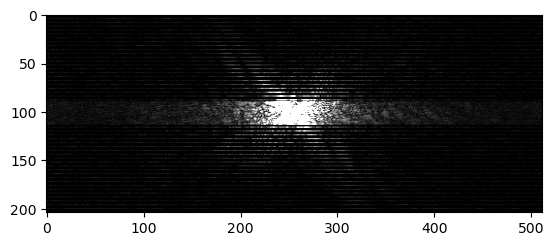

In [18]:
plt.imshow(np.abs(underslice), cmap='gray', vmax = 0.001)

Let's see what the subsampled image looks like:

In [19]:
underslice2 = T.to_tensor(underslice)              # Convert from numpy array to pytorch tensor
sampled_image = fastmri.ifft2c(underslice2)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
#sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

In [20]:
sampled_image_abs.shape

torch.Size([204, 512])

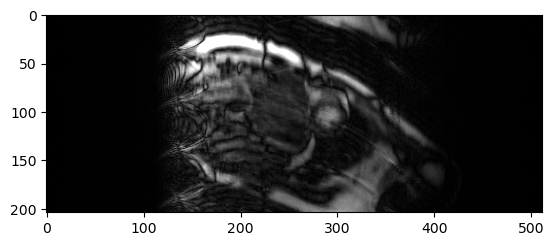

In [21]:
plt.imshow(np.abs(sampled_image_abs.numpy()), cmap='gray',vmax = 0.0015)

Here we try to save the numpy to mat73 file, please use hdf5storage function. 
For a large numpy array, it may take a longer time (e.g. up to two minutes for a multi-coil file). 

In [22]:
def savenumpy2mat(data, np_var, filepath):
    ''' 
    np_var: str, the name of the variable in the mat file.
    data: numpy, array to save.
    filepath: str, the path to save the mat file.
    '''
    savedict= {}
    savedict[np_var] = data
    hdf5storage.savemat(filepath, savedict)


In [23]:
savenumpy2mat(underslice, 'underkspace', 'underkslice.mat')